In [ ]:
# default_exp core

# Using fastai on sequences of Images

> How to use fastai to train an image sequence to image sequence job.

This tutorial uses fastai to process sequences of images. We are going to look at two tasks:
- First we will do video classification on the UCF101 dataset. You will learn how to convert the video to individual frames. We will also build a data processing piepline using fastai's mid level API. Finally we will build some simple models and assess our accuracy.
- Secondly, we will predict future frames of MNIST digits moving on the screen. We will have to create our syhtetic dataset first, then we will train a simple model to forecast future frames.

In [ ]:
#all_slow

In [ ]:
#export
from fastai.vision.all import *

Fix an issue on fastai 2.3, this [PR](https://github.com/fastai/fastai/pull/3298) should fix it

In [ ]:
#export
@patch
def one_batch(self: Learner, i, b):
    self.iter = i
    b_on_device = to_device(b, device=self.dls.device) if self.dls.device is not None else b
    self._split(b_on_device)
    self._with_events(self._do_one_batch, 'batch', CancelBatchException)

## UCF101 Action Recognition

> UCF101 is an action recognition data set of realistic action videos, collected from YouTube, having 101 action categories. This data set is an extension of UCF50 data set which has 50 action categories.

_"With 13320 videos from 101 action categories, UCF101 gives the largest diversity in terms of actions and with the presence of large variations in camera motion, object appearance and pose, object scale, viewpoint, cluttered background, illumination conditions, etc, it is the most challenging data set to date. As most of the available action recognition data sets are not realistic and are staged by actors, UCF101 aims to encourage further research into action recognition by learning and exploring new realistic action categories"_

### setup

We have to download the UCF101 dataset from their website. It is a big dataset (6.5GB), if your connection is slow you may want to do this at night or in a terminal (to avoid blocking the notebook).  fastai's `untar_data` is not capable of downloading this dataset, so we will use `wget` and then unrar the files using `rarfile`.

`fastai`'s datasets are located inside `~/.fastai/archive`, we will download UFC101 there.

In [ ]:
#slow
# !wget -P ~/.fastai/archive/ --no-check-certificate  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar 

> you can run this command on a terminal to avoid blocking the notebook

Let's make a function to`unrar` the downloaded dataset. This function is very similar to `untar_data`, but handles `.rar` files.

In [ ]:
#export
from rarfile import RarFile
    
def unrar(fname, dest):
    "Extract `fname` to `dest` using `rarfile`"
    dest = URLs.path(c_key='data')/fname.name.withsuffix('') if dest is None else dest
    print(f'extracting to: {dest}')
    if not dest.exists():
        fname = str(fname)
        if fname.endswith('rar'):  
            with RarFile(fname, 'r') as myrar:
                myrar.extractall(dest.parent)
        else: 
            raise Exception(f'Unrecognized archive: {fname}')
        rename_extracted(dest)
    return dest

To be consistent, we will extract UCF dataset in `~/.fasta/data`. This is where fastai stores decompressed datasets.

In [ ]:
ucf_fname = Path.home()/'.fastai/archive/UCF101.rar'
dest = Path.home()/'.fastai/data/UCF101'

> unraring a large file like this one is very slow.

In [ ]:
#slow
path = unrar(ucf_fname, dest)

extracting to: /home/tcapelle/.fastai/data/UCF101


The file structure of the dataset after extraction is one folder per action:

In [ ]:
path.ls()

(#101) [Path('/home/tcapelle/.fastai/data/UCF101/Hammering'),Path('/home/tcapelle/.fastai/data/UCF101/HandstandPushups'),Path('/home/tcapelle/.fastai/data/UCF101/HorseRace'),Path('/home/tcapelle/.fastai/data/UCF101/FrontCrawl'),Path('/home/tcapelle/.fastai/data/UCF101/LongJump'),Path('/home/tcapelle/.fastai/data/UCF101/GolfSwing'),Path('/home/tcapelle/.fastai/data/UCF101/ApplyEyeMakeup'),Path('/home/tcapelle/.fastai/data/UCF101/UnevenBars'),Path('/home/tcapelle/.fastai/data/UCF101/HeadMassage'),Path('/home/tcapelle/.fastai/data/UCF101/Kayaking')...]

inside, you will find  one video per instance, the videos are in `.avi` format. We will need to convert each video to a sequence of images to able to work with our fastai vision toolset.
> Note: torchvision has a built-in video reader that may be capable of simplifying this task

```
UCF101-frames

├── ApplyEyeMakeup
|   |── v_ApplyEyeMakeup_g01_c01.avi
|   ├── v_ApplyEyeMakeup_g01_c02.avi
|   |   ...
├── Hammering
|   ├── v_Hammering_g01_c01.avi
|   ├── v_Hammering_g01_c02.avi
|   ├── v_Hammering_g01_c03.avi
|   |   ...
...
├── YoYo
    ├── v_YoYo_g01_c01.avi
    ...
    ├── v_YoYo_g25_c03.avi

```

we can grab all videos at one using `get_files` and passing the `'.avi` extension

In [ ]:
video_paths = get_files(path, extensions='.avi')
video_paths[0:4]

(#4) [Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g22_c05.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g21_c05.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g03_c03.avi'),Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g18_c02.avi')]

We can convert the videos to frames using `av`:

In [ ]:
#export
import av

In [ ]:
#export
def extract_frames(video_path):
    "convert video to PIL images "
    video = av.open(str(video_path))
    for frame in video.decode(0):
        yield frame.to_image()

In [ ]:
frames = list(extract_frames(video_paths[0]))
frames[0:4]

[<PIL.Image.Image image mode=RGB size=320x240 at 0x7F2C87D161F0>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7F2C87D0CBE0>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7F2C87D0CD30>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7F2C87D0CD90>]

We have`PIL.Image` objects, so we can directly show them using fastai's `show_images` method

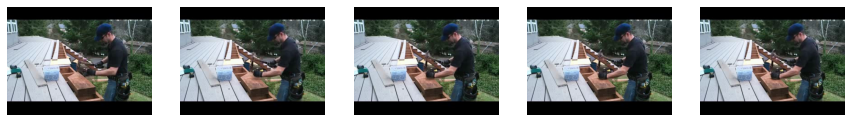

In [ ]:
show_images(frames[0:5])

let's grab one video path

In [ ]:
video_path = video_paths[0]
video_path

Path('/home/tcapelle/.fastai/data/UCF101/Hammering/v_Hammering_g22_c05.avi')

We want to export all videos to frames, les't built a function that is capable of exporting one video to frames, and stores the resulting frames on a folder of the same name.

Let's grab de folder name:

In [ ]:
video_path.relative_to(video_path.parent.parent).with_suffix('')

Path('Hammering/v_Hammering_g22_c05')

we will also create a new directory for our `frames` version of UCF. You will need at least 7GB to do this, afterwards you can erase the original UCF101 folder containing the videos.

In [ ]:
path_frames = path.parent/'UCF101-frames'
if not path_frames.exists(): path_frames.mkdir()

we will make a function that takes a video path, and extracts the frames to our new `UCF-frames` dataset with the same folder structure.

In [ ]:
#export
def avi2frames(video_path, path_frames, force=False):
    "Extract frames from avi file to jpgs"
    dest_path = path_frames/video_path.relative_to(video_path.parent.parent).with_suffix('')
    if not dest_path.exists() or force:
        dest_path.mkdir(parents=True, exist_ok=True)
        for i, frame in enumerate(extract_frames(video_path)):
            frame.save(dest_path/f'{i}.jpg')

In [ ]:
avi2frames(video_path, path_frames)
(path_frames/video_path.relative_to(video_path.parent.parent).with_suffix('')).ls()

(#161) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/63.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/90.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/19.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/111.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/132.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/59.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/46.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/130.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/142.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g22_c05/39.jpg')...]

Now we can batch process the whole dataset using fastcore's `parallel`. This could be slow on a low CPU count machine. On a 12 core machine it takes 4 minutes.

In [ ]:
#slow
#parallel(avi2frames, video_paths)

after this you get a folder hierarchy that looks like this

```
UCF101-frames

├── ApplyEyeMakeup
|   |── v_ApplyEyeMakeup_g01_c01
|   │   ├── 0.jpg
|   │   ├── 100.jpg
|   │   ├── 101.jpg
|   |   ...
|   ├── v_ApplyEyeMakeup_g01_c02
|   │   ├── 0.jpg
|   │   ├── 100.jpg
|   │   ├── 101.jpg
|   |   ...
├── Hammering
|   ├── v_Hammering_g01_c01
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
|   ├── v_Hammering_g01_c02
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
|   ├── v_Hammering_g01_c03
|   │   ├── 0.jpg
|   │   ├── 1.jpg
|   │   ├── 2.jpg
|   |   ...
...
├── YoYo
    ├── v_YoYo_g01_c01
    │   ├── 0.jpg
    │   ├── 1.jpg
    │   ├── 2.jpg
    |   ...
    ├── v_YoYo_g25_c03
        ├── 0.jpg
        ├── 1.jpg
        ├── 2.jpg
        ...
        ├── 136.jpg
        ├── 137.jpg

```

### Data pipeline

we have converted all the videos to images, we are ready to start building our fastai data pieline

In [ ]:
data_path = Path.home()/'.fastai/data/UCF101-frames'
data_path.ls()[0:3]

(#3) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering'),Path('/home/tcapelle/.fastai/data/UCF101-frames/HandstandPushups'),Path('/home/tcapelle/.fastai/data/UCF101-frames/HorseRace')]

we have one folder per action category, and inside one folder per instance of the action. 

In [ ]:
#export
def get_instances(path):
    " gets all instances folders paths"
    sequence_paths = []
    for actions in path.ls():
        sequence_paths += actions.ls()
    return sequence_paths

with this function we get individual instances of each action, **these are the image sequences that we need to clasiffy.**. We will build a pipeline that takes as input **instance path**'s.

In [ ]:
instances_path = get_instances(data_path)
instances_path[0:3]

(#3) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g07_c03'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g13_c07')]

we have to sort the video frames numerically. We will patch pathlib's `Path` class to return a list of files conttaines on a folde sorted numerically. It could be a good idea to modify fastcore's `ls` method with an optiional argument `sort_func`.

In [ ]:
#export
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [ ]:
instances_path[0].ls_sorted()

(#187) [Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/0.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/1.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/2.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/3.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/4.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/5.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/6.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/7.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/8.jpg'),Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02/9.jpg')...]

let's grab the first 5 frames

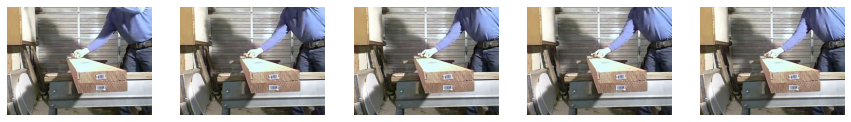

In [ ]:
frames = instances_path[0].ls_sorted()[0:5]
show_images([Image.open(img) for img in frames])

We will build a tuple that contains individual frames and that can show themself. We will use the same idea that on the `siamese_tutorial`. As a video can have many frames, and we don't want to display them all, the `show` method will only display the 1st, middle and last images.

In [ ]:
#export
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

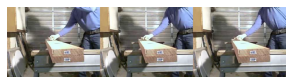

In [ ]:
ImageTuple(PILImage.create(fn) for fn in frames).show();

we will use the mid-level API to create our Dataloader from a transformed list. 

In [ ]:
#export
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20, step=1):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, self.step*min(self.seq_len, n_frames), self.step)
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
tfm = ImageTupleTfm(seq_len=5, step=1)
hammering_instance = instances_path[0]
hammering_instance

Path('/home/tcapelle/.fastai/data/UCF101-frames/Hammering/v_Hammering_g14_c02')

<AxesSubplot:>

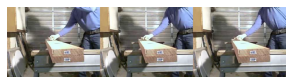

In [ ]:
tfm(hammering_instance).show()

with this setup, we can use the `parent_label` as our labelleing function

In [ ]:
parent_label(hammering_instance)

'Hammering'

In [ ]:
splits = RandomSplitter()(instances_path)

We will use fastai`Datasets` class, we have to pass a `list` of transforms. The first list `[ImageTupleTfm(5)]` is how we grab the `x`'s and the second list `[parent_label, Categorize]]` is how we grab the `y`'s.' So, from each instance path, we grab the first 5 images to construct an `ImageTuple` and we grad the label of the action from the parent folder using `parent_label` and the we `Categorize` the labels.

In [ ]:
ds = Datasets(instances_path, tfms=[[ImageTupleTfm(5)], [parent_label, Categorize]], splits=splits)

In [ ]:
len(ds)

13320

In [ ]:
dls = ds.dataloaders(bs=4, after_item=[Resize(128), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

refactoring

In [ ]:
#export
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, step=1, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len, step=step)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

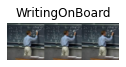

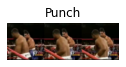

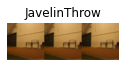

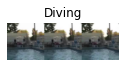

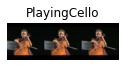

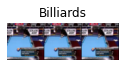

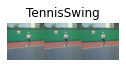

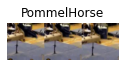

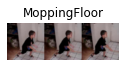

In [ ]:
dls = get_action_dataloaders(instances_path, bs=32, image_size=64, seq_len=5)
dls.show_batch()

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_models.ipynb.
Converted index.ipynb.
